# 1. Introduccion
### En este cuaderno vamos a practicar haciendo mas de una red neuronal convolucional a un dataset de imágenes:
* https://www.kaggle.com/datasets/imsparsh/flowers-dataset/data (clasificación multiclase)
### Este dataset como veremos a continuación, contiene ejemplos de imágenes divididos en 5 tipos de flores:
* daisy (margarita)
* dandelio (diente de leon)
* rose (rosa)
* sunflower (girasol)
* tulip (tulipan)
### y nuestro deber será intentar crear un modelo que nos ayude a diferenciar entre clases.

# 2. Clasificación Multiclase MODELO 1 (5 tipos de flores)

### 2.1 Importamos el dataset

In [121]:
import os
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Descargar el dataset
import kagglehub
path = kagglehub.dataset_download("imsparsh/flowers-dataset")
print("Path to dataset files:", path)

# Definir las rutas de las carpetas
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

# Cargar imágenes de entrenamiento y asignar etiquetas
train_images = []
train_labels = []

for class_name in os.listdir(train_dir):  # Recorremos las carpetas de cada clase
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Verificamos que sea una carpeta
        images = glob(os.path.join(class_path, "*.jpg"))  # Obtenemos todas las imágenes .jpg
        train_images.extend(images)
        train_labels.extend([class_name] * len(images))  # Asignamos la etiqueta correspondiente

# Verificar cuántas imágenes hay por clase
contador_train = Counter(train_labels)
print("Cantidad de imágenes por clase (Entrenamiento):", contador_train)

# Verificar la carpeta de test
test_images = glob(os.path.join(test_dir, "*.jpg"))
print(f"Cantidad de imágenes en la carpeta de test: {len(test_images)}")

Path to dataset files: C:\Users\domid\.cache\kagglehub\datasets\imsparsh\flowers-dataset\versions\2
Cantidad de imágenes por clase (Entrenamiento): Counter({'dandelion': 646, 'tulip': 607, 'daisy': 501, 'rose': 497, 'sunflower': 495})
Cantidad de imágenes en la carpeta de test: 924


### 2.2 Mostrar imágenes aleatorias (de train)

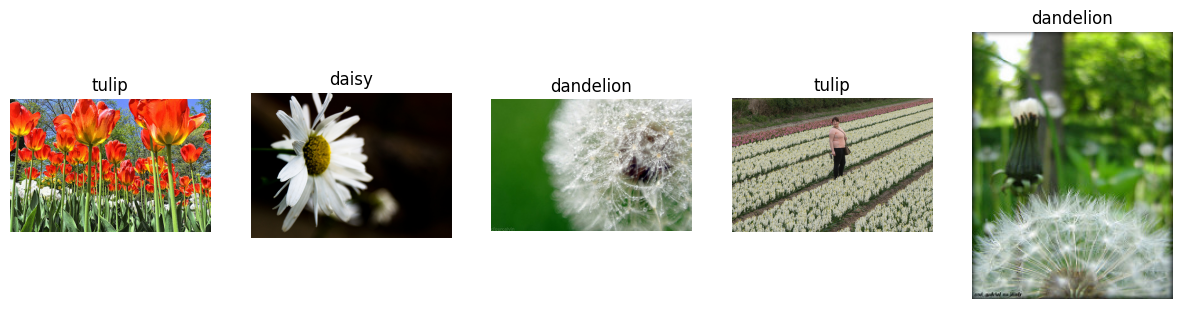

In [122]:
# Mostrar algunas imágenes aleatorias de entrenamiento
def mostrar_imagenes_aleatorias(imagenes, etiquetas, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        idx = random.randint(0, len(imagenes) - 1)
        img = mpimg.imread(imagenes[idx])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(etiquetas[idx])
        plt.axis("off")
    plt.show()

mostrar_imagenes_aleatorias(train_images, train_labels, n=5)

### 2.3 Preprocesamos las imágenes

In [123]:
import tensorflow as tf
# Definir el tamaño al que redimensionaremos las imágenes
IMG_SIZE = (224, 224)

# Función para cargar y preprocesar imágenes
def preprocess_image(image_path, label=None):
    # Leer la imagen desde el archivo
    image = tf.io.read_file(image_path)
    # Decodificar la imagen (asumimos que son JPG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensionar la imagen al tamaño deseado
    image = tf.image.resize(image, IMG_SIZE)
    # Normalizar los valores de los píxeles entre 0 y 1
    image = image / 255.0
    # Si hay una etiqueta, devolverla junto con la imagen
    if label is not None:
        return image, label
    return image

### 2.4 preprocesamos el dataset de entrenamiento y prueba

In [124]:
# Crear un diccionario para mapear las clases a números
class_names = sorted(set(train_labels))  # Obtener las clases únicas y ordenarlas
class_indices = {name: idx for idx, name in enumerate(class_names)}  # Mapear nombres a índices
print("Mapeo de clases a índices:", class_indices)

# Convertir las etiquetas de texto a números
train_labels_numeric = [class_indices[label] for label in train_labels]

# Preprocesar las imágenes de entrenamiento con etiquetas numéricas
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_numeric))
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Preprocesar las imágenes de prueba (sin etiquetas, si no las tienes)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configurar los datasets (opcional: agrupar en lotes y prefetch para mejorar el rendimiento)
BATCH_SIZE = 32
train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verificar el tamaño de las imágenes preprocesadas
for image, label in train_ds.take(1):  # Tomar un lote de entrenamiento
    print(f"Tamaño de las imágenes: {image.shape}")
    print(f"Etiquetas: {label.numpy()}")

Mapeo de clases a índices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Tamaño de las imágenes: (32, 224, 224, 3)
Etiquetas: [1 2 1 4 4 1 3 3 3 4 1 3 2 1 4 2 2 4 1 3 0 0 3 0 4 1 2 3 0 4 0 3]


### 2.5 Definimos el modelo

In [125]:
from tensorflow.keras import layers, models

# Crear el modelo
modelo = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar y capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 clases de flores
])

from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar el resumen del modelo
modelo.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### 2.6 Entrenamos el modelo
#### Antes de entrenar el modelo vamos a separar train_ds y dejar el 20% de sus datos para validación, porque donde solo tenemos etiquetas es en train, las imágenes de test las usaremos mas adelante para hacer predit() y ver como se comporta en datos nuevos

In [126]:
# Separar el 20% de los datos para validación
val_size = int(len(train_images) * 0.2)

# Convertir a tensores
all_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_numeric))
all_ds = all_ds.shuffle(len(train_images), seed=42)

# Separar en entrenamiento y validación
val_ds = all_ds.take(val_size)
train_ds = all_ds.skip(val_size)

# Preprocesar ambos
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Agrupar en lotes y optimizar
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [127]:
# Entrenar el modelo
EPOCHS = 4
historial = modelo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.3056 - loss: 1.5553 - val_accuracy: 0.5064 - val_loss: 1.2171
Epoch 2/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 379ms/step - accuracy: 0.4872 - loss: 1.2234 - val_accuracy: 0.6102 - val_loss: 0.9799
Epoch 3/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 382ms/step - accuracy: 0.5625 - loss: 1.0509 - val_accuracy: 0.6740 - val_loss: 0.8837
Epoch 4/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 380ms/step - accuracy: 0.6438 - loss: 0.9299 - val_accuracy: 0.6903 - val_loss: 0.9145


### 2.7 Rendimiento

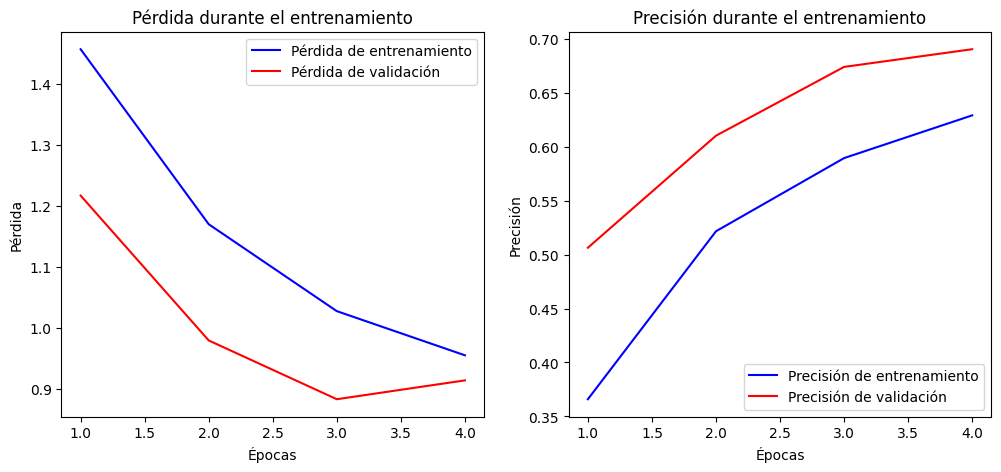

In [128]:
import matplotlib.pyplot as plt

# Graficar la pérdida y precisión
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, historial.history['loss'], 'b', label='Pérdida de entrenamiento')
plt.plot(epochs, historial.history['val_loss'], 'r', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial.history['accuracy'], 'b', label='Precisión de entrenamiento')
plt.plot(epochs, historial.history['val_accuracy'], 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### 2.8 Predicción sobre datos de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


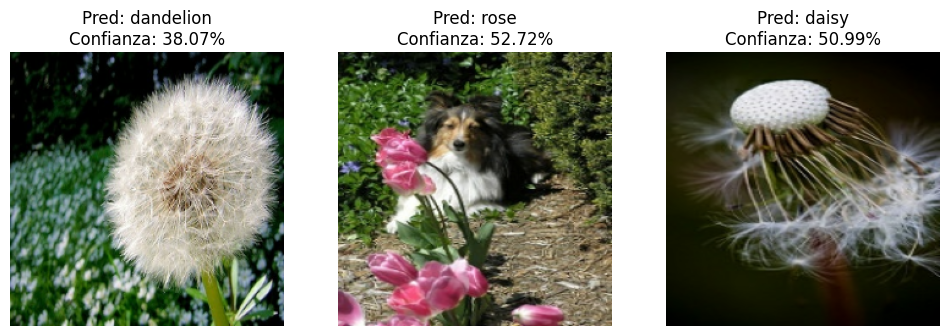

In [129]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Función para cargar y preprocesar imágenes
def preprocess_image(image_path):
    # Leer la imagen desde el archivo
    image = tf.io.read_file(image_path)
    # Decodificar la imagen (asumimos que son JPG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensionar la imagen al tamaño deseado
    image = tf.image.resize(image, (224, 224))
    # Normalizar los valores de los píxeles entre 0 y 1
    image = image / 255.0
    return image

# Función para mostrar imágenes y predicciones
def mostrar_predicciones(modelo, test_images, num_imagenes=3):
    """
    Muestra imágenes aleatorias junto con sus predicciones y confianza del modelo.

    Parámetros:
    - modelo: El modelo de clasificación a usar para las predicciones.
    - test_images: Lista de imágenes de prueba.
    - clases: Diccionario de clases mapeadas a etiquetas (índices).
    - num_imagenes: Número de imágenes aleatorias a mostrar.
    """
    # Definir las clases dentro de la función
    clases = {
        0: 'daisy',
        1: 'dandelion',
        2: 'rose',
        3: 'sunflower',
        4: 'tulip'
    }

    # Seleccionar imágenes aleatorias de test_images
    random_images = random.sample(test_images, num_imagenes)

    # Listas para almacenar las imágenes, predicciones y confianza
    imagenes = []
    predicciones_muestradas = []
    confianza_muestrada = []

    # Preprocesar y hacer predicciones para las imágenes seleccionadas
    for img_file in random_images:
        # Cargar y preprocesar la imagen
        imagen = preprocess_image(img_file)
        
        # Añadir una dimensión para el batch (1, 224, 224, 3)
        imagen = tf.expand_dims(imagen, axis=0)
        
        # Obtener la predicción para esta imagen
        prediccion = modelo.predict(imagen)  # Usamos el modelo proporcionado
        pred_clase = np.argmax(prediccion, axis=1)  # Obtener la clase predicha
        confianza = np.max(prediccion)  # Obtener la confianza de la predicción (probabilidad máxima)
        
        # Guardamos la imagen, la clase predicha y la confianza
        imagenes.append(imagen[0])  # Almacenamos la imagen sin la dimensión extra
        predicciones_muestradas.append(clases[pred_clase[0]])  # La clase predicha
        confianza_muestrada.append(confianza)  # La probabilidad de la predicción

    # Verificamos si tenemos alguna imagen para mostrar
    if len(imagenes) > 0:
        # Mostrar las imágenes con sus predicciones y la confianza
        fig, axes = plt.subplots(1, num_imagenes, figsize=(12, 4))

        for i, ax in enumerate(axes):
            ax.imshow(imagenes[i])
            ax.set_title(f"Pred: {predicciones_muestradas[i]}\nConfianza: {confianza_muestrada[i]*100:.2f}%")
            ax.axis('off')

        plt.show()
    else:
        print("No se encontraron imágenes válidas para mostrar.")

mostrar_predicciones(modelo, test_images)

## 3. Clasificación Multiclase MODELO 2
* Más profundidad en la estructura de la red neuronal
* Entrenamiento más amplio con 10 épocas

In [130]:
from tensorflow.keras import layers, models

# Crear el modelo más profundo
modelo_profundizado = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Cuarta capa convolucional (aumentando la profundidad)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Quinta capa convolucional (más profundidad)
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Aplanar las imágenes para pasarlas a las capas densas
    layers.Flatten(),
    
    # Capa densa intermedia
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularización (Dropout) para evitar sobreajuste
    
    # Capa densa final
    layers.Dense(5, activation='softmax')  # 5 clases (por las flores)
])

# Compilar el modelo
modelo_profundizado.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Resumen del modelo para ver las capas y parámetros
modelo_profundizado.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,125,253 (31.00 MB)

 Trainable params: 8,125,253 (31.00 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1 Entrenamiento

In [131]:
# Entrenar el modelo
EPOCHS = 10  # Puedes aumentar el número de épocas para entrenar más tiempo si es necesario
historial = modelo_profundizado.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 451ms/step - accuracy: 0.2869 - loss: 1.5770 - val_accuracy: 0.4353 - val_loss: 1.2959
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 444ms/step - accuracy: 0.4433 - loss: 1.2376 - val_accuracy: 0.5537 - val_loss: 1.1199
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 444ms/step - accuracy: 0.5361 - loss: 1.1268 - val_accuracy: 0.6193 - val_loss: 1.0317
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 450ms/step - accuracy: 0.6320 - loss: 0.9361 - val_accuracy: 0.6594 - val_loss: 0.8441
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 459ms/step - accuracy: 0.6654 - loss: 0.8163 - val_accuracy: 0.7268 - val_loss: 0.7385
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - accuracy: 0.6643 - loss: 0.8365 - val_accuracy: 0.7505 - val_loss: 0.6250
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 449ms/step - accuracy: 0.7360 - loss: 0.7115 - val_accuracy: 0.7413 - val_loss: 0.6356
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - accuracy: 0.7474 - loss: 0.6598 - val_accu

### 3.2 Gráfica de perdida y precisión

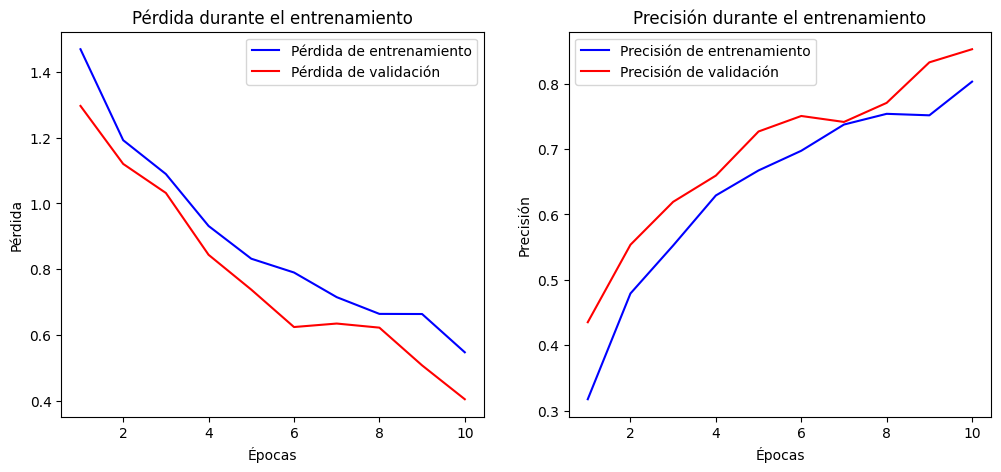

In [132]:
# Graficar la pérdida y precisión
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, historial.history['loss'], 'b', label='Pérdida de entrenamiento')
plt.plot(epochs, historial.history['val_loss'], 'r', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial.history['accuracy'], 'b', label='Precisión de entrenamiento')
plt.plot(epochs, historial.history['val_accuracy'], 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### 3.3 Predicción sobre datos de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


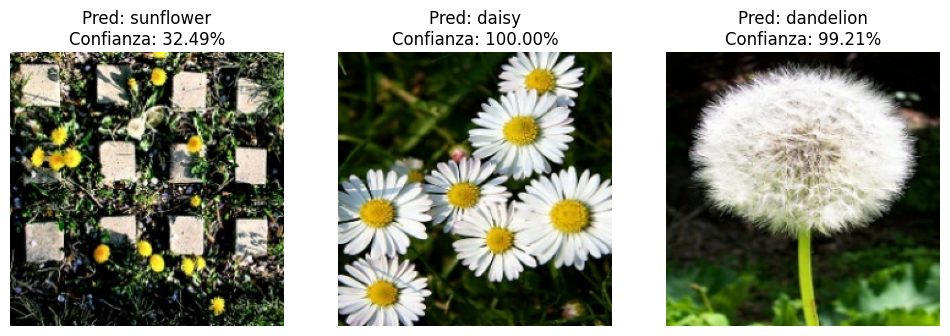

In [140]:
mostrar_predicciones(modelo_profundizado, test_images)

## 4. MODELO 3 Modelo usando transfer learning con MobileNetV2

### 4.1 Preprocesamiento de imágenes para 

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Cargar MobileNetV2 preentrenado sin la capa superior
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",  # Cargar pesos preentrenados en ImageNet
    input_shape=(224, 224, 3),  # Tamaño de entrada para las imágenes
    include_top=False  # No incluir la capa superior (clasificador)
)

# Congelar las capas del modelo base (preentrenado)
base_model.trainable = False

# Crear el modelo completo
modelo_mobilenet = models.Sequential([
    base_model,  # Añadir el modelo base
    layers.GlobalAveragePooling2D(),  # Promedio global para reducir dimensiones
    layers.Dense(128, activation='relu'),  # Capa densa intermedia
    layers.Dense(5, activation='softmax')  # 5 clases de flores (categorías)
])

# Compilar el modelo
modelo_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss='sparse_categorical_crossentropy',  # Función de pérdida para clasificación multiclase
                         metrics=['accuracy'])

# Mostrar el resumen del modelo
modelo_mobilenet.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4.2 Montar y Entrenamiento del modelo con mobilenet 

In [135]:
# Entrenar el modelo con el dataset de entrenamiento y validación
EPOCHS = 4
historial_mobilenet = modelo_mobilenet.fit(
    train_ds,  # Dataset de entrenamiento
    validation_data=val_ds,  # Dataset de validación
    epochs=EPOCHS  # Número de épocas
)


Epoch 1/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.6584 - loss: 0.8771 - val_accuracy: 0.8670 - val_loss: 0.3359
Epoch 2/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 0.9074 - loss: 0.2903 - val_accuracy: 0.9399 - val_loss: 0.2168
Epoch 3/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.9310 - loss: 0.2118 - val_accuracy: 0.9636 - val_loss: 0.1404
Epoch 4/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.9634 - loss: 0.1379 - val_accuracy: 0.9745 - val_loss: 0.0933


### 4.3 Métricas de pérdida y precisión

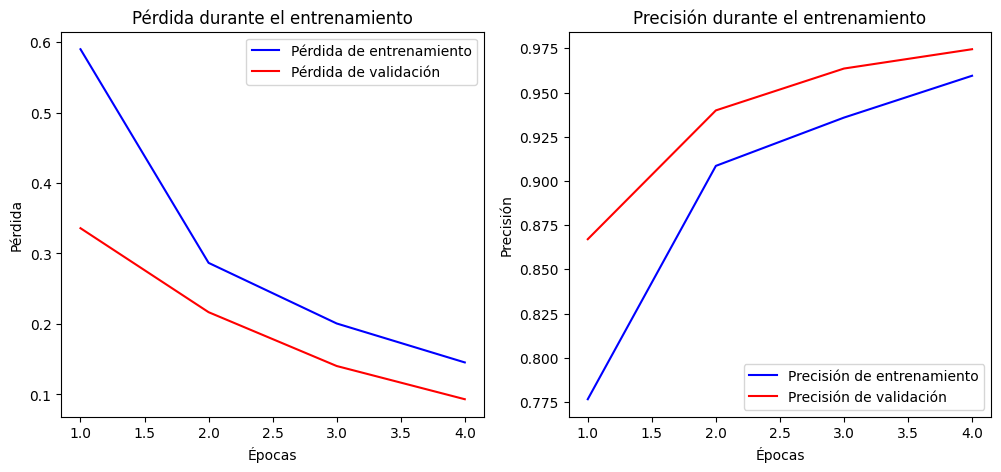

In [136]:
import matplotlib.pyplot as plt

# Número de épocas
epochs = range(1, len(historial_mobilenet.history['loss']) + 1)

# Graficar la pérdida y precisión
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, historial_mobilenet.history['loss'], 'b', label='Pérdida de entrenamiento')
plt.plot(epochs, historial_mobilenet.history['val_loss'], 'r', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial_mobilenet.history['accuracy'], 'b', label='Precisión de entrenamiento')
plt.plot(epochs, historial_mobilenet.history['val_accuracy'], 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


### 4.4 Predicción sobre datos de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


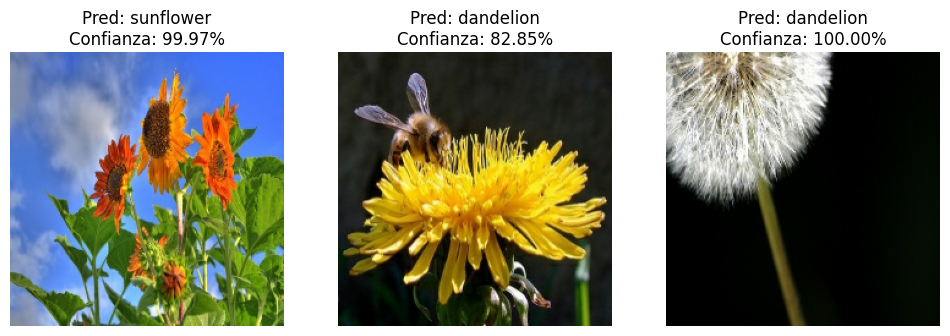

In [145]:
# Mostrar predicciones en 3 imágenes de prueba aleatorias
mostrar_predicciones(modelo_mobilenet, test_images)

## 5. Comparación de los 3 modelos
* modelo 1 (modelo normal (4 capas convulacionales(32, 64, 128) y 1 densa(128)) con 4 épocas de entrenamiento)
* modelo 2 (modelo profundo (5 capas convulacionales(32, 64, 128, 256) y densa(256)) con 10 épocas)
* modelo 3 (modelo MobileNetV2 y capa densa(128) con 4 épocas)

| Modelo     | Épocas | Tiempo Total | Precisión Entrenamiento Final | Pérdida Entrenamiento Final | Precisión Validación Final | Pérdida Validación Final |
|------------|--------|--------------|------------------------------|-----------------------------|----------------------------|---------------------------|
| **Modelo 1** | 4      | 1min 35s     | 0.6407                       | 0.9201                      | 0.6849                     | 0.9238                    |
| **Modelo 2** | 10     | 4min 36s     | 0.7807                       | 0.5920                      | 0.8124                     | 0.4804                    |
| **Modelo 3** | 4      | 1min 17s     | 0.9625                       | 0.1340                      | 0.9745                     | 0.0919                    |

### Se ve claramente la evolucion entre el modelo 1 y 2 simplemente por agregarle profundidad a la red neuronal y más épocas de entrenamiento, esto se pudo comprobar que funcionaría fijandonos en la métrica de perdida y precision durante el entrenamiento, tenía como tendencia a que esto podría ocurrir. Tenemos mejores resultados, pero por otra parte, nos tardará el entrenamiento 3 minutos más
### Y ya al utilizar el transfern learning con el modelo entrenado de keras MobileNetV2, obtenemos unos resultados casi perfectos, pudiendo diferenciar como vemos en la celda de arriba casi todas las imágenes de test (que son mas de 900), este modelo también hay que decir que es muy rápido y eficiente, tardando menos que el primer modelo.